In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import poligrain as plg
import xarray as xr
import os, sys

# OpenRainER

In [3]:
# open data
ds_gauges = xr.open_dataset("data/covi_2024_OpenRainER/AWS_rainfall.nc")
ds_rad = xr.open_dataset("data/adjusted_radar_OpenRainER.nc")
ds_cmls = xr.open_dataset("data/processed_cml_OpenRainER.nc") 

# Resample to 15 min resolution
ds_cmls = ds_cmls.R_acc.resample(time = '15min', label='right', closed='right').sum(skipna=True)
ds_cmls = ds_cmls.reduce(np.nanmean, dim='sublink_id')

# Slice in time 
start = '2022-08-01T00'
end = '2022-08-31T00'
ds_gauges = ds_gauges.sel(time = slice(start, end))
ds_rad = ds_rad.sel(time = slice(start, end)) 
ds_cmls = ds_cmls.sel(time = slice(start, end)) 

In [4]:
(
    ds_cmls.coords["site_0_x"],
    ds_cmls.coords["site_0_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_0_lon, ds_cmls.site_0_lat, "EPSG:32632"
)
(
    ds_cmls.coords["site_1_x"],
    ds_cmls.coords["site_1_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_1_lon, ds_cmls.site_1_lat, "EPSG:32632"
)

In [5]:
#  GAUGES VALUES FROM RADAR FILDS PERSPECTIVE
ds_gauges = ds_gauges.rename({'longitude':'lon', 'latitude':'lat'})

ds_gauges.coords["x"], ds_gauges.coords["y"] = plg.spatial.project_point_coordinates(
    ds_gauges.lon, ds_gauges.lat, "EPSG:32632"
)

get_grid_at_points = plg.spatial.GridAtPoints(
    da_gridded_data=ds_rad.isel(time = 0), 
    da_point_data=ds_gauges.isel(time = 0),
    nnear=1,
    stat="best",
)

ds_gauges['rainfall_radar'] = get_grid_at_points(
    da_gridded_data=ds_rad.rainfall_amount,
    da_point_data=ds_gauges.rainfall_amount,  
)

ds_gauges['adjust_idw'] = get_grid_at_points(
    da_gridded_data=ds_rad.rainfall_additiveIDW,
    da_point_data=ds_gauges.rainfall_amount,  
)

ds_gauges['adjust_bk'] = get_grid_at_points(
    da_gridded_data=ds_rad.rainfall_additiveBKpoint,
    da_point_data=ds_gauges.rainfall_amount,  
)

ds_gauges['adjust_ked'] = get_grid_at_points(
    da_gridded_data=ds_rad.rainfall_KED,
    da_point_data=ds_gauges.rainfall_amount,  
)

HOW IMPROVMENTS CHANGE WITH THE DISTANCE FROM CMLs

In [6]:
# compute matrix considering rgs at max_distance from cmls

distances = np.arange(2000, 32000, 2000) # [m]
threshold = 0.1
for max_distance in distances:
    closest_neigbors = plg.spatial.get_closest_points_to_line(
        ds_cmls, ds_gauges.rainfall_amount, max_distance=max_distance, n_closest=1
    )

    closest_rgs = closest_neigbors.neighbor_id
    closest_rgs = closest_rgs.where(closest_rgs != None, drop=True)
    ds_closegauges = ds_gauges.sel(id=np.unique(closest_rgs.values.flatten()))

    metrics_rainfall_radar = pd.DataFrame([plg.validation.calculate_rainfall_metrics(
        reference=ds_closegauges.rainfall_amount.values.flatten(),
        estimate=ds_closegauges.rainfall_radar.values.flatten(),
        ref_thresh=threshold,
        est_thresh=threshold,
    )])
    metrics_rainfall_radar['distance'] = [max_distance]

    metrics_adjust_idw = pd.DataFrame([plg.validation.calculate_rainfall_metrics(
        reference=ds_closegauges.rainfall_amount.values.flatten(),
        estimate=ds_closegauges.adjust_idw.values.flatten(),
        ref_thresh=threshold,
        est_thresh=threshold,
    )])
    metrics_adjust_idw['distance'] = [max_distance]

    metrics_adjust_bk = pd.DataFrame([plg.validation.calculate_rainfall_metrics(
        reference=ds_closegauges.rainfall_amount.values.flatten(),
        estimate=ds_closegauges.adjust_bk.values.flatten(),
        ref_thresh=threshold,
        est_thresh=threshold,
    )])
    metrics_adjust_bk['distance'] = [max_distance]

    metrics_adjust_ked = pd.DataFrame([plg.validation.calculate_rainfall_metrics(
        reference=ds_closegauges.rainfall_amount.values.flatten(),
        estimate=ds_closegauges.adjust_ked.values.flatten(),
        ref_thresh=threshold,
        est_thresh=threshold,
    )])
    metrics_adjust_ked['distance'] = [max_distance]

    if max_distance == 2000:
        result_rainfall_radar = metrics_rainfall_radar
        result_adjust_idw = metrics_adjust_idw
        result_adjust_bk = metrics_adjust_bk
        result_adjust_ked = metrics_adjust_ked
    else:
        result_rainfall_radar = pd.concat([result_rainfall_radar, metrics_rainfall_radar])
        result_adjust_idw = pd.concat([result_adjust_idw, metrics_adjust_idw])
        result_adjust_bk = pd.concat([result_adjust_bk, metrics_adjust_bk])
        result_adjust_ked = pd.concat([result_adjust_ked, metrics_adjust_ked])

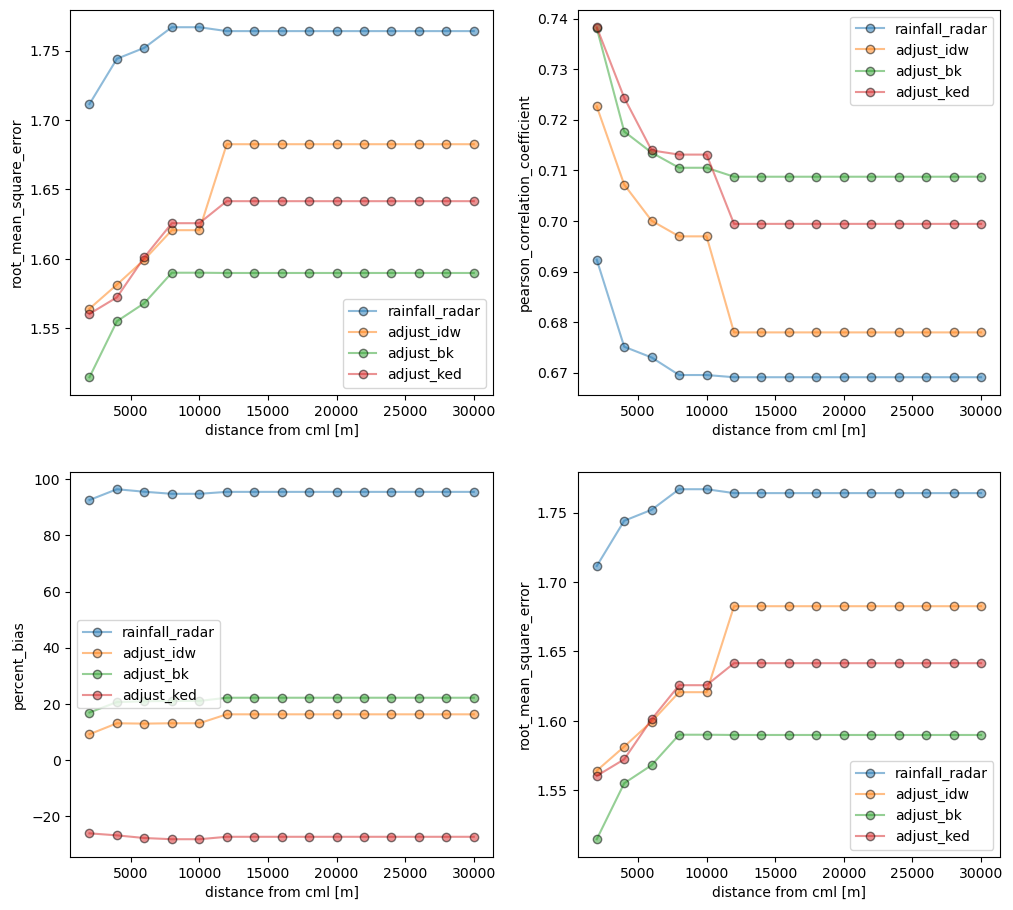

In [7]:
fig, ax = plt.subplots(2,2, figsize=(12, 11))
ax[0,0].plot(result_rainfall_radar.distance, result_rainfall_radar.root_mean_square_error,
        marker='o', markeredgecolor='black', label='rainfall_radar', alpha=.5)
ax[0,0].plot(result_adjust_idw.distance, result_adjust_idw.root_mean_square_error,
        marker='o', markeredgecolor='black', label='adjust_idw', alpha=.5)
ax[0,0].plot(result_adjust_bk.distance, result_adjust_bk.root_mean_square_error,
        marker='o', markeredgecolor='black', label='adjust_bk', alpha=.5)
ax[0,0].plot(result_adjust_ked.distance, result_adjust_ked.root_mean_square_error,
        marker='o', markeredgecolor='black', label='adjust_ked', alpha=.5)
ax[0,0].set_xlabel('distance from cml [m]')
ax[0,0].set_ylabel('root_mean_square_error')
ax[0,0].legend()
ax[0,1].plot(result_rainfall_radar.distance, result_rainfall_radar.pearson_correlation_coefficient,
        marker='o', markeredgecolor='black', label='rainfall_radar', alpha=.5)
ax[0,1].plot(result_adjust_idw.distance, result_adjust_idw.pearson_correlation_coefficient,
        marker='o', markeredgecolor='black', label='adjust_idw', alpha=.5)
ax[0,1].plot(result_adjust_bk.distance, result_adjust_bk.pearson_correlation_coefficient,
        marker='o', markeredgecolor='black', label='adjust_bk', alpha=.5)
ax[0,1].plot(result_adjust_ked.distance, result_adjust_ked.pearson_correlation_coefficient,
        marker='o', markeredgecolor='black', label='adjust_ked', alpha=.5)
ax[0,1].set_xlabel('distance from cml [m]')
ax[0,1].set_ylabel('pearson_correlation_coefficient')
ax[0,1].legend()
ax[1,0].plot(result_rainfall_radar.distance, result_rainfall_radar.percent_bias,
        marker='o', markeredgecolor='black', label='rainfall_radar', alpha=.5)
ax[1,0].plot(result_adjust_idw.distance, result_adjust_idw.percent_bias,
        marker='o', markeredgecolor='black', label='adjust_idw', alpha=.5)
ax[1,0].plot(result_adjust_bk.distance, result_adjust_bk.percent_bias,
        marker='o', markeredgecolor='black', label='adjust_bk', alpha=.5)
ax[1,0].plot(result_adjust_ked.distance, result_adjust_ked.percent_bias,
        marker='o', markeredgecolor='black', label='adjust_ked', alpha=.5)
ax[1,0].set_xlabel('distance from cml [m]')
ax[1,0].set_ylabel('percent_bias')
ax[1,0].legend()
ax[1,1].plot(result_rainfall_radar.distance, result_rainfall_radar.root_mean_square_error,
        marker='o', markeredgecolor='black', label='rainfall_radar', alpha=.5)
ax[1,1].plot(result_adjust_idw.distance, result_adjust_idw.root_mean_square_error,
        marker='o', markeredgecolor='black', label='adjust_idw', alpha=.5)
ax[1,1].plot(result_adjust_bk.distance, result_adjust_bk.root_mean_square_error,
        marker='o', markeredgecolor='black', label='adjust_bk', alpha=.5)
ax[1,1].plot(result_adjust_ked.distance, result_adjust_ked.root_mean_square_error,
        marker='o', markeredgecolor='black', label='adjust_ked', alpha=.5)
ax[1,1].set_xlabel('distance from cml [m]')
ax[1,1].set_ylabel('root_mean_square_error')
ax[1,1].legend()

EVENT ANALYSIS

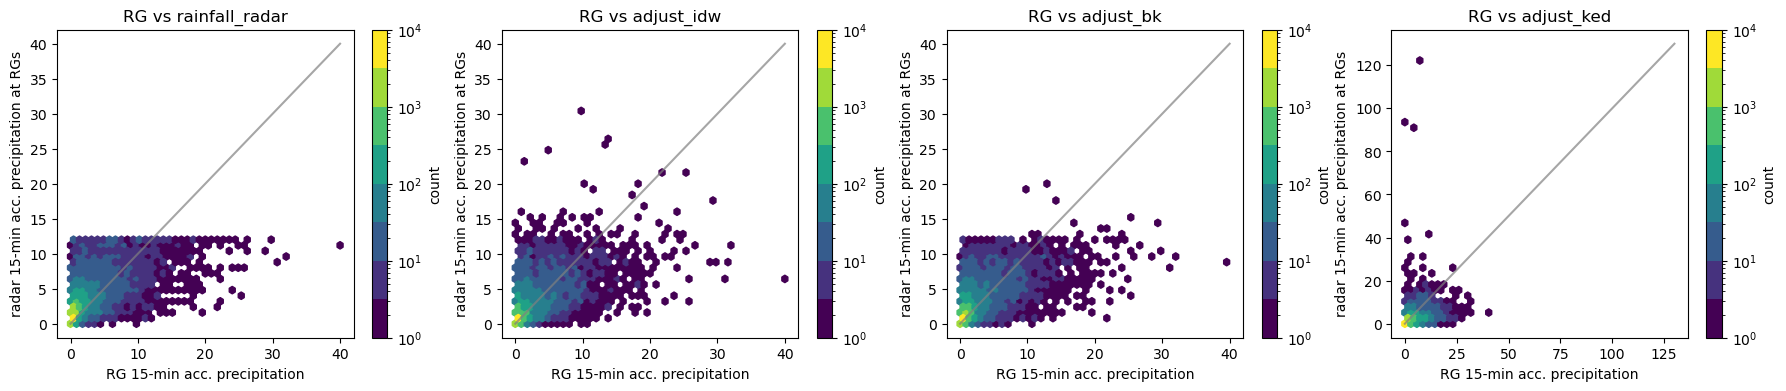

In [8]:
fig, ax = plt.subplots(1, 4, figsize=(22, 4))
hx = plg.validation.plot_hexbin(
    ds_gauges.rainfall_amount.values.flatten(),
    ds_gauges.rainfall_radar.values.flatten(),
    ref_thresh=0.1,
    est_thresh=0.1,
    ax=ax[0],
)
hx = plg.validation.plot_hexbin(
    ds_gauges.rainfall_amount.values.flatten(),
    ds_gauges.adjust_idw.values.flatten(),
    ref_thresh=0.1,
    est_thresh=0.1,
    ax=ax[1],
)
hx = plg.validation.plot_hexbin(
    ds_gauges.rainfall_amount.values.flatten(),
    ds_gauges.adjust_bk.values.flatten(),
    ref_thresh=0.1,
    est_thresh=0.1,
    ax=ax[2],
)
hx = plg.validation.plot_hexbin(
    ds_gauges.rainfall_amount.values.flatten(),
    ds_gauges.adjust_ked.values.flatten(),
    ref_thresh=0.1,
    est_thresh=0.1,
    ax=ax[3],
)
ax[0].set_title('RG vs rainfall_radar')
ax[1].set_title('RG vs adjust_idw')
ax[2].set_title('RG vs adjust_bk')
ax[3].set_title('RG vs adjust_ked')
for i in range(4):
    ax[i].set_ylabel('radar 15-min acc. precipitation at RGs')
    ax[i].set_xlabel('RG 15-min acc. precipitation')

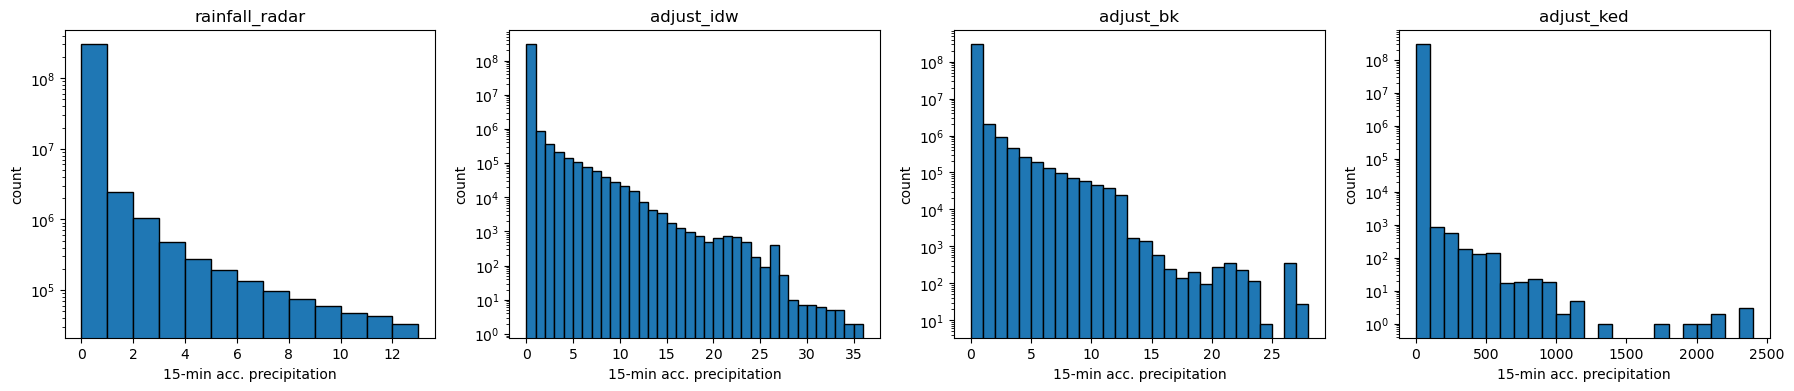

In [9]:
fig, ax = plt.subplots(1, 4, figsize=(22, 4))
val = ds_rad.rainfall_amount.values.flatten()
ax[0].hist(val, bins=np.arange(0, np.nanmax(val)+1, 1), edgecolor='black')
val = ds_rad.rainfall_additiveIDW.values.flatten()
ax[1].hist(val, bins=np.arange(0, np.nanmax(val)+1, 1), edgecolor='black')
val = ds_rad.rainfall_additiveBKpoint.values.flatten()
ax[2].hist(val, bins=np.arange(0, np.nanmax(val)+1, 1), edgecolor='black')
val = ds_rad.rainfall_KED.values.flatten()
ax[3].hist(val, bins=np.arange(0, np.nanmax(val)+100, 100), edgecolor='black')
ax[0].set_title('rainfall_radar')
ax[1].set_title('adjust_idw')
ax[2].set_title('adjust_bk')
ax[3].set_title('adjust_ked')
for i in range(4):
    ax[i].set_ylabel('count')
    ax[i].set_xlabel('15-min acc. precipitation')
    ax[i].set_yscale('log')

In [10]:
ds_rad.rainfall_KED.where(ds_rad.rainfall_KED > 500, drop=True).time.values

array(['2022-08-02T04:15:00.000000000', '2022-08-07T04:00:00.000000000',
       '2022-08-07T04:30:00.000000000', '2022-08-07T04:45:00.000000000',
       '2022-08-07T11:00:00.000000000', '2022-08-18T19:45:00.000000000',
       '2022-08-19T06:00:00.000000000'], dtype='datetime64[ns]')

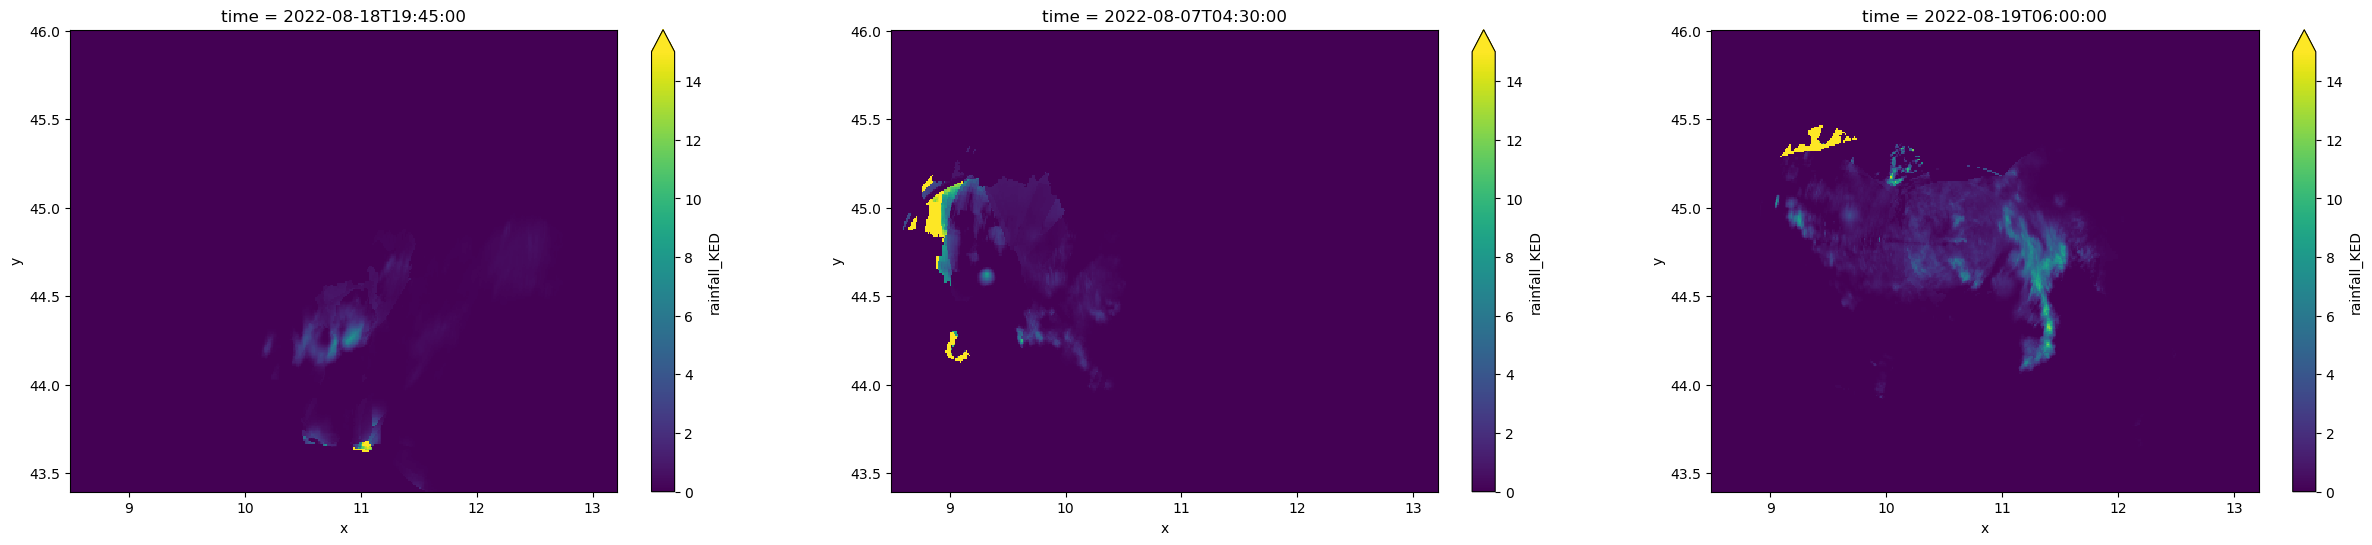

In [19]:
fig, ax=plt.subplots(1,3, figsize=(30,6))
ds_rad.rainfall_KED.sel(time='2022-08-18T19:45:00.000000000').plot(ax=ax[0], vmax=15)
ds_rad.rainfall_KED.sel(time='2022-08-07T04:30:00.000000000').plot(ax=ax[1], vmax=15)
ds_rad.rainfall_KED.sel(time='2022-08-19T06:00:00.000000000').plot(ax=ax[2], vmax=15)

events feature:
* precipitations higher then 5 mm
* notable differences before/after adjustment

In [21]:
ds_gauges['radar_diff'] = ds_gauges['rainfall_amount'] - ds_gauges['rainfall_radar']
ds_gauges['idw_diff'] = ds_gauges['rainfall_amount'] - ds_gauges['adjust_idw']
ds_gauges['bk_diff'] = ds_gauges['rainfall_amount'] - ds_gauges['adjust_bk']
ds_gauges['ked_diff'] = ds_gauges['rainfall_amount'] - ds_gauges['adjust_ked']
mean_diff_gauges = ds_gauges.reduce(np.nanmean, dim='time')

In [14]:
ds_gauges.where((np.abs(ds_gauges.radar_diff) > 8)&(np.abs(ds_gauges.idw_diff) < 1), drop=True).time.values

array(['2022-08-15T16:45:00.000000000', '2022-08-17T18:15:00.000000000',
       '2022-08-21T13:45:00.000000000', '2022-08-28T13:30:00.000000000',
       '2022-08-28T13:45:00.000000000'], dtype='datetime64[ns]')

In [15]:
ds_gauges.where((np.abs(ds_gauges.radar_diff) > 8)&(np.abs(ds_gauges.bk_diff) < 1), drop=True).time.values

array([], dtype='datetime64[ns]')

In [16]:
ds_gauges.where((np.abs(ds_gauges.radar_diff) > 8)&(np.abs(ds_gauges.ked_diff) < 1), drop=True).time.values

array(['2022-08-02T07:30:00.000000000', '2022-08-02T09:45:00.000000000',
       '2022-08-05T14:45:00.000000000', '2022-08-05T21:30:00.000000000',
       '2022-08-06T11:00:00.000000000', '2022-08-06T11:15:00.000000000',
       '2022-08-06T11:45:00.000000000', '2022-08-06T12:30:00.000000000',
       '2022-08-06T17:00:00.000000000', '2022-08-06T17:15:00.000000000',
       '2022-08-06T19:00:00.000000000', '2022-08-06T19:15:00.000000000',
       '2022-08-06T19:30:00.000000000', '2022-08-07T00:30:00.000000000',
       '2022-08-07T00:45:00.000000000', '2022-08-07T02:00:00.000000000',
       '2022-08-07T12:45:00.000000000', '2022-08-07T13:00:00.000000000',
       '2022-08-07T21:00:00.000000000', '2022-08-15T14:30:00.000000000',
       '2022-08-15T16:45:00.000000000', '2022-08-21T13:45:00.000000000',
       '2022-08-21T14:45:00.000000000', '2022-08-22T12:15:00.000000000',
       '2022-08-22T12:30:00.000000000', '2022-08-22T13:00:00.000000000',
       '2022-08-22T13:15:00.000000000', '2022-08-26

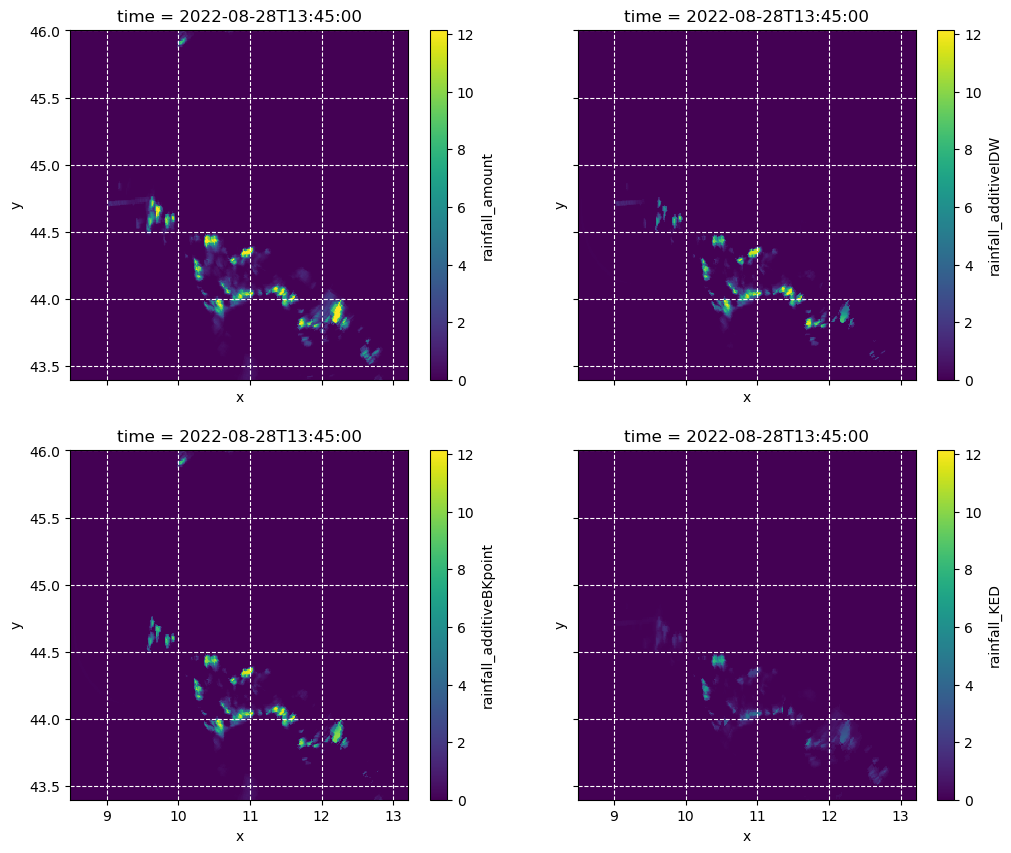

In [25]:
seltime = '2022-08-28T13:45:00.000000000'
#seltime = '2022-08-06T19:00:00.000000000'

vmax = np.nanmax(np.concatenate([ds_rad.rainfall_amount.sel(time = seltime).values.flatten(),
                                 ds_rad.rainfall_additiveIDW.sel(time = seltime).values.flatten(),
                                 ds_rad.rainfall_additiveBKpoint.sel(time = seltime).values.flatten(),
                                 ds_rad.rainfall_KED.sel(time = seltime).values.flatten()], axis=0))

fig, ax=plt.subplots(2,2, figsize=(12,10), sharex=True, sharey=True)
ds_rad.rainfall_amount.sel(time = seltime).plot(ax=ax[0,0], vmin=0, vmax=vmax)
ds_rad.rainfall_additiveIDW.sel(time = seltime).plot(ax=ax[0,1], vmin=0, vmax=vmax)
ds_rad.rainfall_additiveBKpoint.sel(time = seltime).plot(ax=ax[1,0], vmin=0, vmax=vmax)
ds_rad.rainfall_KED.sel(time = seltime).plot(ax=ax[1,1], vmin=0, vmax=vmax)

ax[0,0].grid(linestyle='--', color='white')
ax[1,0].grid(linestyle='--', color='white')
ax[0,1].grid(linestyle='--', color='white')
ax[1,1].grid(linestyle='--', color='white')


In [26]:
data = xr.open_dataset('data/adjusted_radar_OpenMRG.nc')

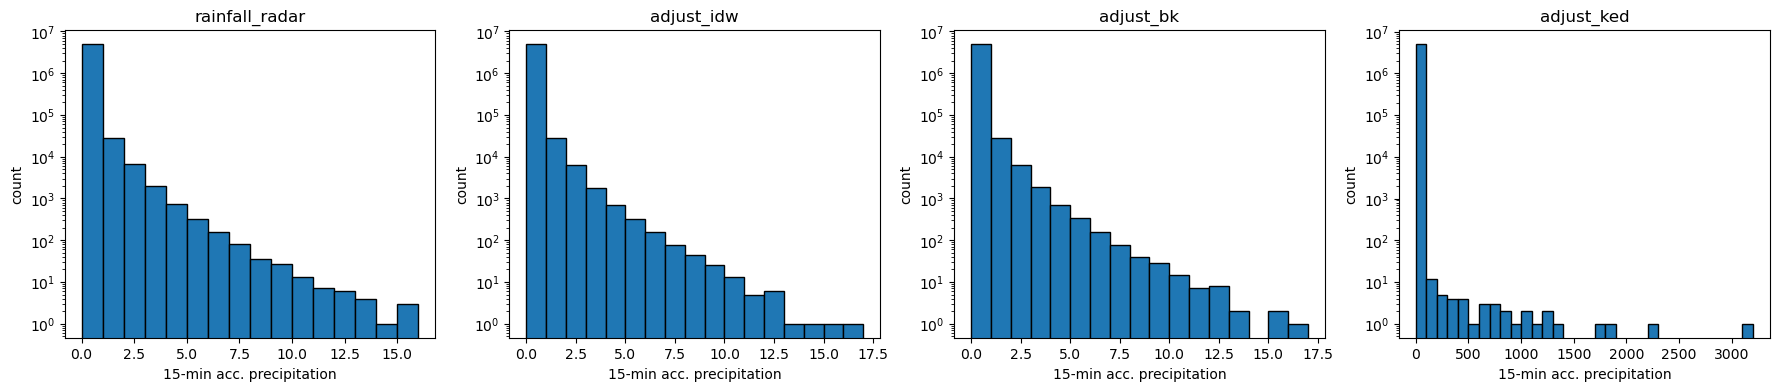

In [27]:
fig, ax = plt.subplots(1, 4, figsize=(22, 4))
val = data.rainfall_amount.values.flatten()
ax[0].hist(val, bins=np.arange(0, np.nanmax(val)+1, 1), edgecolor='black')
val = data.rainfall_additiveIDW.values.flatten()
ax[1].hist(val, bins=np.arange(0, np.nanmax(val)+1, 1), edgecolor='black')
val = data.rainfall_additiveBKpoint.values.flatten()
ax[2].hist(val, bins=np.arange(0, np.nanmax(val)+1, 1), edgecolor='black')
val = data.rainfall_KED.values.flatten()
ax[3].hist(val, bins=np.arange(0, np.nanmax(val)+100, 100), edgecolor='black')
ax[0].set_title('rainfall_radar')
ax[1].set_title('adjust_idw')
ax[2].set_title('adjust_bk')
ax[3].set_title('adjust_ked')
for i in range(4):
    ax[i].set_ylabel('count')
    ax[i].set_xlabel('15-min acc. precipitation')
    ax[i].set_yscale('log')